In [1]:
from librosa.core import load as ld_wav
from librosa.feature import delta
import librosa.feature as ft_extraction
import scipy.io.wavfile as wav
import numpy as np
import os
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
import librosa
from sklearn.metrics.pairwise import euclidean_distances
from operator import itemgetter
import pickle
drive.mount('/content/drive')

Mounted at /content/drive


# Data Extraction

In [2]:
!ls "/content/drive/My Drive/IRMAS-training"

layer1	 layer12  layer4  layer7  LSTM_MODEL  RNN_MODEL
layer10  layer2   layer5  layer8  pia	      vio
layer11  layer3   layer6  layer9  resultados  Y_DATA


In [3]:
# directory where we your .wav files are
directoryName = "/content/drive/My Drive/IRMAS-training" # put your own directory here
#instruments to evaluate
instruments = ["pia","vio"]
# directory to put our results in, you can change the name if you like
resultsDirectory = directoryName + "/MFCCresults"


In [4]:
def countTrainTracks(input_path, labels):
		""" Counts the number of tracks in the folders of the trainset
		"""
		total = 0
		for l, label in enumerate(labels):
			instrument_dir = os.path.join(input_path, label)
			total += len(os.listdir(instrument_dir))

		return total

In [5]:
if not os.path.exists(resultsDirectory):
    os.makedirs(resultsDirectory)

In [6]:
total_tracks = countTrainTracks(directoryName,instruments)
print("Total tracks: ",total_tracks)

Total tracks:  1301


In [7]:
data_dict = dict()
data_dict["rolloff"] = list()
data_dict["bandwidth"] = list()
data_dict["centroids"] = list()
data_dict["zero_crossing_rate"] = list()
data_dict["rms"] = list()
#data_dict["slope"] = list()
#data_dict["kurtosis"] = list()
for i in range(0,13):
    data_dict["mfcc"+str(i)] = list()
data_dict["instrument"] = list()

In [8]:
#Essa funcao recebe cada coluna mfcc[j], que é um vetor onde cada elemento vetor[i]
#contem todos os K coeficientes mfcc[j] de um audio i. O objetivo é descobrir como os MFCC[j] mudam ao longo do tempo.
#Obs: 
#j (quantidade de coeficientes MFCC) = {0,13}, 
#k (quantidade de uma mesma caracteristica extraída do audio completo - depende do tamanho de janela e do tempo de duração) = {0,130}, 
#i (numero de arquivos do dataset) = 1301 
def getDeltaFeat(column):
    #Quantos vetores serão lidos, ou seja, o tamanho do dataset 
    original_len = len(column)
    deltas = list()
    for i in range(original_len):
      deltas.append(delta(column[i], order=1))
    return np.array(deltas)

In [9]:
def includeDeltaFeat(df):
    for i in range(0,13):
        df["delta_mfcc"+str(i)]=getDeltaFeat(df["mfcc"+str(i)])
    return df

In [10]:
def FeatureSpectralCentroid(X, f_s):

    isSpectrum = X.ndim == 1

    # X = X**2 removed for consistency with book

    norm = X.sum(axis=0, keepdims=True)
    norm[norm == 0] = 1

    vsc = np.dot(np.arange(0, X.shape[0]), X) / norm

    # convert from index to Hz
    vsc = vsc / (X.shape[0] - 1) * f_s / 2

    # if input is a spectrum, output scaler else if spectrogram, output 1d array
    vsc = np.squeeze(vsc) if isSpectrum else np.squeeze(vsc, axis=0)

    return vsc

In [11]:
def FeatureSpectralSpread(X, f_s):

    isSpectrum = X.ndim == 1
    if isSpectrum:
        X = np.expand_dims(X, axis=1)

    # get spectral centroid as index
    vsc = FeatureSpectralCentroid(X, f_s) * 2 / f_s * (X.shape[0] - 1)

    # X = X**2 removed for consistency with book

    norm = X.sum(axis=0)
    norm[norm == 0] = 1

    # compute spread
    vss = np.zeros(X.shape[1])
    indices = np.arange(0, X.shape[0])
    for n in range(0, X.shape[1]):
        vss[n] = np.dot((indices - vsc[n])**2, X[:, n]) / norm[n]

    vss = np.sqrt(vss)

    # convert from index to Hz
    vss = vss / (X.shape[0] - 1) * f_s / 2

    return np.squeeze(vss) if isSpectrum else vss

In [12]:
def FeatureSpectralKurtosis(X, f_s, UseBookDefinition=False):

    isSpectrum = X.ndim == 1
    if isSpectrum:
        X = np.expand_dims(X, axis=1)

    if UseBookDefinition:  # not recommended
        # compute mean and standard deviation
        mu_x = np.mean(X, axis=0, keepdims=True)
        std_x = np.std(X, axis=0)

        # remove mean
        X = X - mu_x

        # compute kurtosis
        vsk = np.sum(X**4, axis=0) / (std_x**4 * X.shape[0])
    else:
        f = np.arange(0, X.shape[0]) / (X.shape[0] - 1) * f_s / 2
        # get spectral centroid and spread (mean and std of dist)
        vsc = FeatureSpectralCentroid(X, f_s)  # *2/f_s * (X.shape[0]-1)
        vss = FeatureSpectralSpread(X, f_s)    # *2/f_s * (X.shape[0]-1)

        norm = X.sum(axis=0)
        norm[norm == 0] = 1
        vss[vss == 0] = 1

        # compute kurtosis
        vsk = np.zeros(X.shape[1])
        for n in range(0, X.shape[1]):
            vsk[n] = np.dot((f - vsc[n])**4, X[:, n]) / (vss[n]**4 * norm[n] * X.shape[0])

    return np.squeeze(vsk - 3) if isSpectrum else (vsk - 3)

In [13]:
def FeatureSpectralSlope(X, f_s):

    # compute mean
    mu_x = X.mean(axis=0, keepdims=True)

    # compute index vector
    kmu = np.arange(0, X.shape[0]) - X.shape[0] / 2

    # compute slope
    X = X - mu_x
    vssl = np.dot(kmu, X) / np.dot(kmu, kmu)

    return vssl

In [14]:
(sig,rate) = ld_wav(directoryName +"/"+'pia'+"/" +'001__[pia][nod][cla]1389__1.wav')
spectogram = np.abs(librosa.stft(sig,n_fft=512))
feat = FeatureSpectralSlope(spectogram,rate)
print(np.array(feat).reshape(1,-1).shape)

(1, 517)


In [15]:
ft_extraction.zero_crossing_rate(y=sig,frame_length=512,hop_length=512//4).shape

(1, 517)

In [16]:
def getData(directoryName,instruments,data_dict,seq_len):
    instrument_index = 0
    files_read = 0
    for instrument in instruments:
        for filename in os.listdir(directoryName+"/"+instrument):
            if filename.endswith('.wav'): # only get MFCCs from .wavs
                # read in our file
                (sig,rate) = ld_wav(directoryName +"/"+instrument+"/" +filename)
                #print("Signal len = ",len(sig),"\nRate = ",rate)
                # get mfcc
                spectogram = np.abs(librosa.stft(sig,n_fft=512))
                mfcc_feat = ft_extraction.mfcc(S=spectogram,sr=rate,n_mfcc=13)
                rolloff_feat = ft_extraction.spectral_rolloff(S=spectogram,sr=rate)
                bandwidth_feat = ft_extraction.spectral_bandwidth(S=spectogram,sr=rate)
                centroid_feat = ft_extraction.spectral_centroid(S=spectogram,sr=rate)
                zero_crossing_rate_feat = ft_extraction.zero_crossing_rate(y=sig,frame_length=512,hop_length=512//4)
                rms_feat = ft_extraction.rms(S=spectogram)
                #slope_feat = FeatureSpectralSlope(spectogram,rate)
                #slope_feat = np.array(slope_feat).reshape(1,-1)
                #kurtosis_feat = FeatureSpectralKurtosis(spectogram,rate)
                #kurtosis_feat = np.array(kurtosis_feat).reshape(1,-1)
                for j in range(int(len(rms_feat[0])/seq_len)):
                  data_dict["instrument"].append([instrument_index])
                  for i in range(0,13):
                      data_dict["mfcc"+str(i)].append(mfcc_feat[i,(j*seq_len):((j+1)*seq_len)])
                  data_dict["rolloff"].append(rolloff_feat[0,(j*seq_len):((j+1)*seq_len)])
                  data_dict["bandwidth"].append(bandwidth_feat[0,(j*seq_len):((j+1)*seq_len)])
                  data_dict["centroids"].append(centroid_feat[0,(j*seq_len):((j+1)*seq_len)])
                  data_dict["zero_crossing_rate"].append(zero_crossing_rate_feat[0,(j*seq_len):((j+1)*seq_len)])
                  data_dict["rms"].append(rms_feat[0,(j*seq_len):((j+1)*seq_len)])
                  #data_dict["slope"].append(slope_feat[0,(j*seq_len):((j+1)*seq_len)])
                  #data_dict["kurtosis"].append(kurtosis_feat[0,(j*seq_len):((j+1)*seq_len)])
                #rolloff = ft_extraction.spectral_rolloff(y=sig,sr=rate)
                # create a file to save our results in
                files_read += 1
        instrument_index += 1
    data_dict = includeDeltaFeat(data_dict)
    return data_dict                                                                                           

In [17]:
data_dict = getData(directoryName,instruments,data_dict,517)

In [18]:
len(data_dict["bandwidth"][0])

517

In [19]:
np.count_nonzero(~np.isnan(data_dict["mfcc0"]))

672617

In [20]:
for key in data_dict.keys():
    print(key,len(data_dict[key]))
    #convert list to np
    data_dict[key] = np.array(data_dict[key])

rolloff 1301
bandwidth 1301
centroids 1301
zero_crossing_rate 1301
rms 1301
mfcc0 1301
mfcc1 1301
mfcc2 1301
mfcc3 1301
mfcc4 1301
mfcc5 1301
mfcc6 1301
mfcc7 1301
mfcc8 1301
mfcc9 1301
mfcc10 1301
mfcc11 1301
mfcc12 1301
instrument 1301
delta_mfcc0 1301
delta_mfcc1 1301
delta_mfcc2 1301
delta_mfcc3 1301
delta_mfcc4 1301
delta_mfcc5 1301
delta_mfcc6 1301
delta_mfcc7 1301
delta_mfcc8 1301
delta_mfcc9 1301
delta_mfcc10 1301
delta_mfcc11 1301
delta_mfcc12 1301


In [21]:
#Para o datafram não aceita matriz como input. Como cada arquivo de audio do data se obtem uma matriz de 
#tamanho (tam,n_features) multiplicaremos cada elemento do vetor de saída por esse tamanho. Assim, para um dado audio e para cada linha
#da matriz de dados teremos um valor de saída corresponde. A representação com matriz será util quando utilizarmos redes neurais
#O metodo flatten() transforma 2d arrays em 1d
data_for_df = dict()
data_for_df['instrument'] = list()
for key in data_dict.keys():
  if key != 'instrument':
    data_for_df[key] = data_dict[key].flatten()
    print("Feat {} has len {}".format(key,len(data_for_df[key])))
  else:
    for i in range(len(data_dict['instrument'])):
      data_for_df['instrument'].extend([data_dict['instrument'][i][0]] * len(data_dict['bandwidth'][i]))
df = pd.DataFrame(data_for_df)

Feat rolloff has len 672617
Feat bandwidth has len 672617
Feat centroids has len 672617
Feat zero_crossing_rate has len 672617
Feat rms has len 672617
Feat mfcc0 has len 672617
Feat mfcc1 has len 672617
Feat mfcc2 has len 672617
Feat mfcc3 has len 672617
Feat mfcc4 has len 672617
Feat mfcc5 has len 672617
Feat mfcc6 has len 672617
Feat mfcc7 has len 672617
Feat mfcc8 has len 672617
Feat mfcc9 has len 672617
Feat mfcc10 has len 672617
Feat mfcc11 has len 672617
Feat mfcc12 has len 672617
Feat delta_mfcc0 has len 672617
Feat delta_mfcc1 has len 672617
Feat delta_mfcc2 has len 672617
Feat delta_mfcc3 has len 672617
Feat delta_mfcc4 has len 672617
Feat delta_mfcc5 has len 672617
Feat delta_mfcc6 has len 672617
Feat delta_mfcc7 has len 672617
Feat delta_mfcc8 has len 672617
Feat delta_mfcc9 has len 672617
Feat delta_mfcc10 has len 672617
Feat delta_mfcc11 has len 672617
Feat delta_mfcc12 has len 672617


In [22]:
len(data_dict[key].flatten())

672617

In [23]:
517*1301

672617

(1301x130)x31

In [24]:
input_variables = list(df.columns)
input_variables.remove("instrument")
output_variable = "instrument"
print(input_variables)

['rolloff', 'bandwidth', 'centroids', 'zero_crossing_rate', 'rms', 'mfcc0', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'delta_mfcc0', 'delta_mfcc1', 'delta_mfcc2', 'delta_mfcc3', 'delta_mfcc4', 'delta_mfcc5', 'delta_mfcc6', 'delta_mfcc7', 'delta_mfcc8', 'delta_mfcc9', 'delta_mfcc10', 'delta_mfcc11', 'delta_mfcc12']


# Preprocessing

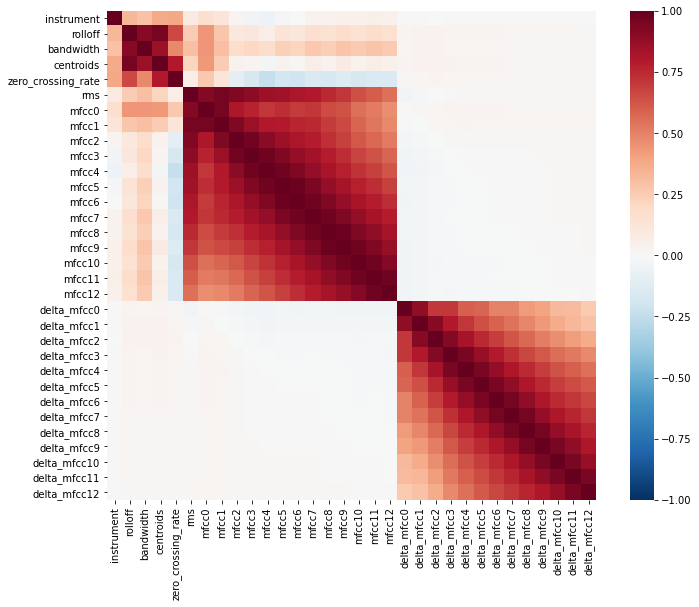

In [25]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat,cmap=sns.color_palette("RdBu_r", 1000), vmin=-1,vmax=1, square=True)
plt.savefig('CorrelationMatrix.png')
plt.show()

In [26]:
scaler = StandardScaler()
pca = PCA(n_components=0.9)
Y = df[output_variable]
df[input_variables] = scaler.fit_transform(df[input_variables])
df = pca.fit_transform(df[input_variables])
df = pd.DataFrame(df)
df[output_variable] = Y

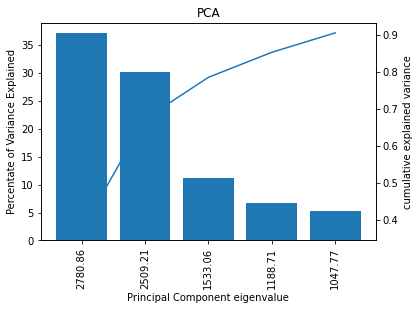

In [27]:
percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)
result = pca.explained_variance_ratio_
plt.bar(x= sorted(np.arange(len(result)),reverse=True), height=sorted(percent_variance,reverse=True),tick_label=np.round(sorted(pca.singular_values_,reverse=True),decimals=2) )
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component eigenvalue')
plt.xticks(rotation=90)
plt.title('PCA')
ax = plt.gca()
# set the xlimits to be the reverse of the current xlimits
ax.set_xlim(ax.get_xlim()[::-1])
# call `draw` to re-render the graph
plt.draw()

axes2 = plt.twinx()
axes2.plot(np.arange(len(result)),sorted(np.cumsum(result),reverse=True))
axes2.set_ylabel('cumulative explained variance')
plt.savefig('PCA.png')
plt.show()

In [28]:
np.unique(df['instrument'])

array([0, 1])

In [29]:
df.shape

(672617, 6)

In [30]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(instruments)
print(le.inverse_transform([0,1]))

['pia' 'vio']


In [31]:
df

,0,1,2,3,4,instrument
0,0.080758,-1.082748,-1.929547,0.176707,-0.644650,0
1,0.098806,-1.080851,-1.979647,0.172734,-0.198289,0
2,-0.311799,-1.077349,-2.066912,0.168163,0.090843,0
3,-0.205685,-1.081100,-2.149440,0.175321,0.029290,0
4,0.076336,-1.087623,-2.240317,0.182803,-0.090429,0
...,...,...,...,...,...,...
672612,-1.362675,-0.631063,-0.960393,0.604464,-0.538991,1
672613,-1.699189,-0.621338,-0.742245,0.590332,-0.559080,1
672614,-1.759530,-0.617922,-0.754897,0.588465,-0.205275,1
672615,-1.919855,-0.613835,-0.675125,0.580832,-0.121908,1


# Random Forest

In [56]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,0:21], df[output_variable], test_size=0.33, random_state=42)
rfc = RandomForestClassifier(n_estimators=100, random_state=0)
rfc.fit(X_train, y_train)
y_predict = rfc.predict(X_test)

In [ ]:
from sklearn import metrics
print(metrics.confusion_matrix(le.inverse_transform(y_test),le.inverse_transform(y_predict)))
print(metrics.classification_report(le.inverse_transform(y_test),le.inverse_transform(y_predict),digits=3))

In [ ]:
df.shape

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
  

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [ ]:
plot_confusion_matrix(le.inverse_transform(y_test),le.inverse_transform(y_predict), classes=['Piano', 'Violino'], title='Confusion matrix')
plt.savefig("ConfusionMatrix.png")

In [ ]:
probs = rfc.predict_proba(X_test)
preds = probs[:,1]
def plot_AUC(preds,title,y_test):
  fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
  roc_auc = metrics.auc(fpr, tpr)

  plt.title('ROC AUC - '+title)
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.savefig('ROC_plot'+title+'.png')
  plt.show()

plot_AUC(preds,"Random Forest",y_test)

# Neural Networks 

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.metrics import AUC,Precision,Recall,BinaryCrossentropy,Accuracy
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  #raise SystemError('GPU device not found')
  print('Not found')
print('Found GPU at: {}'.format(device_name))

In [58]:
#Converter o dicionario para uma unica matriz concatenando os arrays em colunas
X = np.array([data_dict[key] for key in input_variables])
Y = data_dict['instrument'].flatten()
# Anteriormente para cada conjunto de caracteristicas extraídas efetuamos a classificação. Logo tinhamos vetores de tamanho n_features 
# Agora, para uma determina sequencia de caracteristicas extraidas efetuaremos a classificação. Logo teremos agora uma matrix:
# (tam_seq,n_features). Consideraremos cada linha dessa matriz sendo o tempo
#X.shape == (31,1301,130)
#Mas queremos que X.shape = (1301,130,31)
X = np.transpose(X,(1,2,0))
X_train, X_test, y_train, y_test = train_test_split(X,Y,
                                                    test_size=0.33,
                                                    random_state=42)


In [ ]:
opt = tf.keras.optimizers.Nadam(
    learning_rate=0.0001, beta_1=0.9, beta_2=0.999,
    name='NAdam'
)
#0.001

In [ ]:
def get_LSTM_Model(input_shape):
  model = Sequential()
  model.add(layers.BatchNormalization(input_shape=input_shape))
  model.add(layers.LSTM(256, return_sequences=True,dropout=0.8))
  model.add(layers.TimeDistributed(layers.Dense(64,activation='relu')))
  model.add(layers.TimeDistributed(layers.Dense(32,activation='relu')))
  model.add(layers.TimeDistributed(layers.Dense(16,activation='relu')))
  model.add(layers.TimeDistributed(layers.Dense(8,activation='relu')))
  model.add(layers.Flatten())
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(32,activation='relu'))
  model.add(layers.Dense(16,activation='relu'))
  model.add(layers.Dense(8,activation='relu'))
  model.add(layers.Dense(1,activation='sigmoid'))
  model.summary()
  model.compile(optimizer=opt,loss='binary_crossentropy')
  return model


In [ ]:
def get_RNN_Model(input_shape):
  model = Sequential()
  model.add(layers.BatchNormalization(input_shape=input_shape))
  model.add(layers.SimpleRNN(256, return_sequences=True,dropout=0.8))
  model.add(layers.TimeDistributed(layers.Dense(64,activation='relu')))
  model.add(layers.TimeDistributed(layers.Dense(32,activation='relu')))
  model.add(layers.TimeDistributed(layers.Dense(16,activation='relu')))
  model.add(layers.TimeDistributed(layers.Dense(8,activation='relu')))
  model.add(layers.Flatten())
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(32,activation='relu'))
  model.add(layers.Dense(16,activation='relu'))
  model.add(layers.Dense(8,activation='relu'))
  model.add(layers.Dense(1,activation='sigmoid'))
  model.summary()
  model.compile(optimizer=opt,loss='binary_crossentropy')
  return model


In [72]:
def get_CNN_Model(input_shape):
    model = Sequential()
    model.add(layers.Conv2D(4,(3,3),activation='relu',input_shape=(input_shape),padding="same",strides=(1,1)))
    model.add(layers.MaxPooling2D((2,2),padding='same'))
    model.add(layers.Conv2D(8,(3,3),activation='relu',padding="same",strides=(1,1)))
    model.add(layers.MaxPooling2D((2,2),padding='same'))
    model.add(layers.Conv2D(16,(3,3),activation='relu',padding="same",strides=(1,1)))
    model.add(layers.MaxPooling2D((2,2),padding='same'))
    model.add(layers.Conv2D(32,(3,3),activation='relu',padding="same",strides=(1,1)))
    model.add(layers.MaxPooling2D((2,2),padding='same'))
    model.add(layers.Conv2D(64,(3,3),activation='relu',padding="same",strides=(1,1)))
    model.add(layers.MaxPooling2D((2,2),padding='same'))
    model.add(layers.Conv2D(128,(3,3),activation='relu',padding="same",strides=(1,1)))
    model.add(layers.MaxPooling2D((2,2),padding='same'))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128,activation='relu'))
    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32,activation='relu'))
    model.add(layers.Dense(16,activation='relu'))
    model.add(layers.Dense(1,activation='sigmoid'))
    model.summary()
    model.compile(optimizer=opt,loss='binary_crossentropy')
    return model

In [67]:
class NN_model:
  def __init__(self,model_type,input_shape,allow_early_stop=False,load_from=''):
    self.model_type = model_type
    #Pega o input shape, sendo o primeiro valor None para indicar que depende do tamanho do batch
    #input_shape 
    self.input_shape = input_shape
    self.allow_early_stop = allow_early_stop
    if load_from == '':
      if model_type == 'RNN':
        self.model = get_RNN_Model(self.input_shape)
      if model_type == 'LSTM':
        self.model = get_LSTM_Model(self.input_shape)
      if model_type == 'CNN':
        self.model = get_CNN_Model(self.input_shape)
    else:
        self.model = tf.keras.models.load_model(load_from)
    

  def train(self,X,Y):   
    if self.allow_early_stop:
      earlystop_callback = tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss', min_delta=0.0001,
                            patience=10,
                            restore_best_weights=True
                            )
      #obtem um conjunto de validacao para evitar overfitting
      X_train, X_val, y_train, y_val  = train_test_split(X,Y, test_size=0.2, random_state=42)  
      self.model.fit(X_train,y_train,epochs=400,shuffle=True,
                     validation_data=(X_val,y_val),
                     callbacks=[earlystop_callback])
    else:
      self.model.fit(X,Y,epochs=400,shuffle=True)
  
  def test(self,X_test,y_test,plot_results=True):
    nn_output = self.model.predict(X_test)
    if plot_results:
      y_predict = np.round(nn_output)
      y_predict = list(y_predict.astype('int16').flatten())
      y_test = list(y_test.flatten())   
      print(metrics.confusion_matrix(le.inverse_transform(y_test),le.inverse_transform(y_predict)))
      print(metrics.classification_report(le.inverse_transform(y_test),le.inverse_transform(y_predict),digits=3))
      plot_confusion_matrix(le.inverse_transform(y_test),le.inverse_transform(y_predict), classes=['Piano', 'Violino'], title='Confusion matrix')
      plt.savefig("ConfusionMatrix"+self.model_type+".png")
      plt.show()      
      plot_AUC(nn_output,self.model_type,y_test)
    return nn_output



## LSTM

Epoch 1/100
28/28 [==============================] - 44s 1s/step - loss: 0.0648
Epoch 2/100
28/28 [==============================] - 40s 1s/step - loss: 0.0515
Epoch 3/100
28/28 [==============================] - 40s 1s/step - loss: 0.0726
Epoch 4/100
28/28 [==============================] - 40s 1s/step - loss: 0.0762
Epoch 5/100
28/28 [==============================] - 40s 1s/step - loss: 0.0537
Epoch 6/100
28/28 [==============================] - 40s 1s/step - loss: 0.0608
Epoch 7/100
28/28 [==============================] - 40s 1s/step - loss: 0.0554
Epoch 8/100
28/28 [==============================] - 40s 1s/step - loss: 0.0721
Epoch 9/100
28/28 [==============================] - 40s 1s/step - loss: 0.0775
Epoch 10/100
28/28 [==============================] - 40s 1s/step - loss: 0.0760
Epoch 11/100
28/28 [==============================] - 40s 1s/step - loss: 0.0718
Epoch 12/100
28/28 [==============================] - 40s 1s/step - loss: 0.0698
Epoch 13/100
28/28 [=================

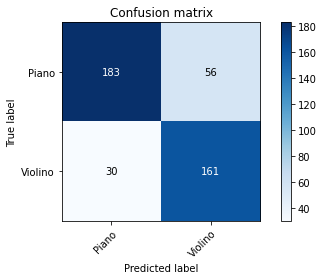

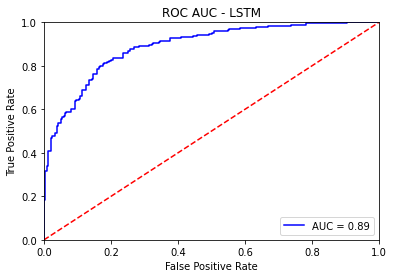

array([[6.75101757e-01],
       [9.96952355e-01],
       [7.50585241e-06],
       [1.16012394e-02],
       [9.99487638e-01],
       [5.98030492e-05],
       [9.65046406e-01],
       [9.99813318e-01],
       [9.99981523e-01],
       [7.27031946e-01],
       [9.99993682e-01],
       [9.99769568e-01],
       [9.99985933e-01],
       [9.96564984e-01],
       [9.97201025e-01],
       [4.32133675e-04],
       [9.97988343e-01],
       [2.52127647e-04],
       [9.29358304e-02],
       [8.98662300e-09],
       [6.21034265e-01],
       [9.99999523e-01],
       [9.99974668e-01],
       [9.99578953e-01],
       [6.26111627e-02],
       [7.91585445e-03],
       [9.98884439e-04],
       [1.73248038e-09],
       [9.94301438e-01],
       [1.06706080e-04],
       [9.93344605e-01],
       [2.29716301e-04],
       [9.99993086e-01],
       [7.71540508e-05],
       [1.10767126e-01],
       [3.00836563e-03],
       [9.99998808e-01],
       [9.58611369e-01],
       [1.28794717e-08],
       [1.38613582e-03],


In [ ]:
myModel = NN_model('LSTM',X_train.shape[1:3],allow_early_stop=False,load_from=directoryName+'/LSTM_MODEL')
myModel.train(X_train,y_train)
myModel.test(X_test,y_test)

In [ ]:
myModel.model.save(directoryName+'/LSTM_MODEL')

INFO:tensorflow:Assets written to: /content/drive/My Drive/IRMAS-training/LSTM_MODEL/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/IRMAS-training/LSTM_MODEL/assets


## Simple RNN

Epoch 1/100
28/28 [==============================] - 15s 432ms/step - loss: 0.1110
Epoch 2/100
28/28 [==============================] - 12s 436ms/step - loss: 0.1136
Epoch 3/100
28/28 [==============================] - 12s 440ms/step - loss: 0.1373
Epoch 4/100
28/28 [==============================] - 12s 438ms/step - loss: 0.1312
Epoch 5/100
28/28 [==============================] - 12s 436ms/step - loss: 0.1281
Epoch 6/100
28/28 [==============================] - 12s 437ms/step - loss: 0.1250
Epoch 7/100
28/28 [==============================] - 12s 435ms/step - loss: 0.1065
Epoch 8/100
28/28 [==============================] - 12s 437ms/step - loss: 0.1251
Epoch 9/100
28/28 [==============================] - 12s 439ms/step - loss: 0.0948
Epoch 10/100
28/28 [==============================] - 12s 438ms/step - loss: 0.0957
Epoch 11/100
28/28 [==============================] - 12s 435ms/step - loss: 0.1058
Epoch 12/100
28/28 [==============================] - 12s 436ms/step - loss: 0.1234
E

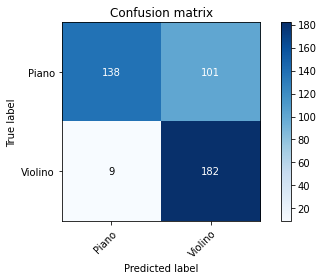

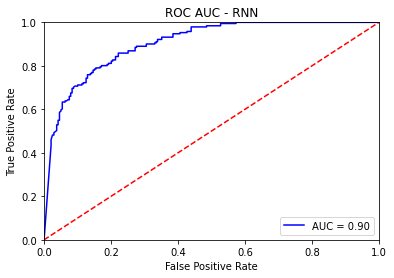

array([[9.49507117e-01],
       [9.43208754e-01],
       [1.48072839e-03],
       [8.29558730e-01],
       [1.00000000e+00],
       [3.72320414e-04],
       [9.99937892e-01],
       [1.00000000e+00],
       [9.99994874e-01],
       [9.99963164e-01],
       [1.00000000e+00],
       [9.99997795e-01],
       [1.00000000e+00],
       [9.99997377e-01],
       [1.00000000e+00],
       [4.20543147e-05],
       [9.99999762e-01],
       [2.95162201e-04],
       [2.81355977e-02],
       [6.80740868e-06],
       [1.70403242e-01],
       [1.00000000e+00],
       [9.99999642e-01],
       [9.99999285e-01],
       [3.70460749e-03],
       [7.85539627e-01],
       [8.77791345e-02],
       [4.25955903e-07],
       [1.00000000e+00],
       [4.23648953e-03],
       [9.99999285e-01],
       [1.06680393e-03],
       [1.00000000e+00],
       [2.27271289e-01],
       [9.99959230e-01],
       [1.00000000e+00],
       [9.99999285e-01],
       [9.99996901e-01],
       [6.19384664e-05],
       [1.60385072e-02],


In [ ]:
myModel2 = NN_model('RNN',input_shape=X_train.shape[1:3],allow_early_stop=False,load_from=directoryName+'/RNN_MODEL')
myModel2.train(X_train,y_train)
myModel2.test(X_test,y_test)

In [ ]:
myModel2.model.save(directoryName+'/RNN_MODEL')

INFO:tensorflow:Assets written to: /content/drive/My Drive/IRMAS-training/RNN_MODEL/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/IRMAS-training/RNN_MODEL/assets


In [ ]:
def getExtractionModel(up_to=1,model=None):
  extractor = Sequential()
  for i in range(up_to):
    extractor.add(model.layers[i])
  return extractor

In [ ]:
os.mkdir(directoryName+"/Y_DATA")
np.save(directoryName+"/Y_DATA"+"/y_train",y_train)
np.save(directoryName+"/Y_DATA"+"/y_test",y_test)
for num in range(1,len(myModel2.model.layers)):
  os.mkdir(directoryName+"/layer{}".format(num))
  extractor = getExtractionModel(num,myModel2.model)
  train_features = np.array(extractor.predict(X_train))
  np.save(directoryName+"/layer{}/extracted_train".format(num),train_features)
  test_features = np.array(extractor.predict(X_test))
  np.save(directoryName+"/layer{}/extracted_test".format(num),test_features)

In [ ]:
getExtractionModel(1,myModel2.model).summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_10 (Batc (None, 517, 31)           124       
Total params: 124
Trainable params: 62
Non-trainable params: 62
_________________________________________________________________


## CNN

In [70]:
inp = list(X_train.shape[1:3])
inp.append(1)
inp

[517, 31, 1]

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 517, 31, 4)        40        
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 259, 16, 4)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 259, 16, 8)        296       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 130, 8, 8)         0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 130, 8, 16)        1168      
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 65, 4, 16)         0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 65, 4, 32)       

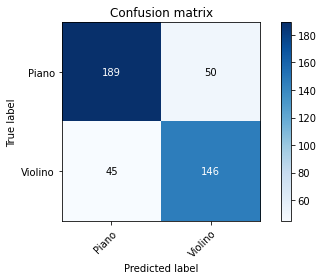

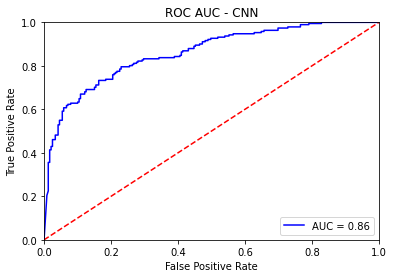

array([[8.24098706e-01],
       [9.99995470e-01],
       [1.44769197e-11],
       [2.35156585e-06],
       [3.57619703e-01],
       [3.13917141e-08],
       [9.44312778e-05],
       [9.99999762e-01],
       [5.11876762e-01],
       [9.96583879e-01],
       [5.55545986e-01],
       [9.99996781e-01],
       [9.99600768e-01],
       [9.99927163e-01],
       [1.00000000e+00],
       [1.80631876e-04],
       [9.99999404e-01],
       [9.98183131e-01],
       [4.48428392e-02],
       [1.25858221e-12],
       [6.13212585e-04],
       [1.00000000e+00],
       [1.00000000e+00],
       [9.99992788e-01],
       [1.48094594e-02],
       [7.42962956e-03],
       [3.67205138e-12],
       [3.09269817e-05],
       [9.93921041e-01],
       [4.92480103e-06],
       [9.99997735e-01],
       [1.25834242e-06],
       [9.99999762e-01],
       [2.51162946e-01],
       [9.23836708e-01],
       [9.99759436e-01],
       [1.00000000e+00],
       [2.76365876e-03],
       [2.78997762e-11],
       [3.59502792e-07],


In [73]:
myModel3 = NN_model('CNN',inp,allow_early_stop=False)
train_reshaped = np.array(X_train)
test_reshaped = np.array(X_test)
train_reshaped = train_reshaped.reshape(-1,X_train.shape[1],X_train.shape[2],1)
test_reshaped = test_reshaped.reshape(-1,X_test.shape[1],X_test.shape[2],1)
myModel3.train(train_reshaped,y_train)
myModel3.test(test_reshaped,y_test)

INFO:tensorflow:Assets written to: /content/drive/My Drive/IRMAS-training/CNN_MODEL/assets
[[189  50]
 [ 45 146]]
              precision    recall  f1-score   support

         pia      0.808     0.791     0.799       239
         vio      0.745     0.764     0.755       191

    accuracy                          0.779       430
   macro avg      0.776     0.778     0.777       430
weighted avg      0.780     0.779     0.779       430



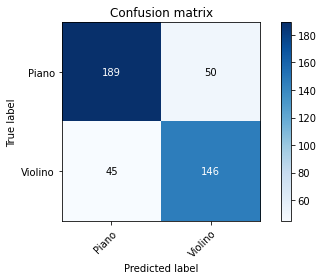

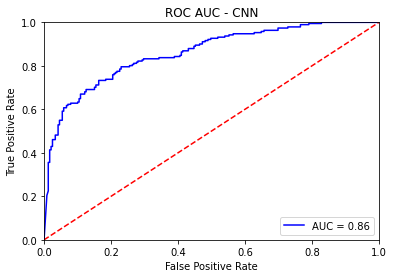

array([[8.24098706e-01],
       [9.99995470e-01],
       [1.44769197e-11],
       [2.35156585e-06],
       [3.57619703e-01],
       [3.13917141e-08],
       [9.44312778e-05],
       [9.99999762e-01],
       [5.11876762e-01],
       [9.96583879e-01],
       [5.55545986e-01],
       [9.99996781e-01],
       [9.99600768e-01],
       [9.99927163e-01],
       [1.00000000e+00],
       [1.80631876e-04],
       [9.99999404e-01],
       [9.98183131e-01],
       [4.48428392e-02],
       [1.25858221e-12],
       [6.13212585e-04],
       [1.00000000e+00],
       [1.00000000e+00],
       [9.99992788e-01],
       [1.48094594e-02],
       [7.42962956e-03],
       [3.67205138e-12],
       [3.09269817e-05],
       [9.93921041e-01],
       [4.92480103e-06],
       [9.99997735e-01],
       [1.25834242e-06],
       [9.99999762e-01],
       [2.51162946e-01],
       [9.23836708e-01],
       [9.99759436e-01],
       [1.00000000e+00],
       [2.76365876e-03],
       [2.78997762e-11],
       [3.59502792e-07],


In [75]:
myModel3.model.save(directoryName+'/CNN_MODEL')
myModel3 = NN_model('CNN',inp,allow_early_stop=False,load_from=directoryName+'/CNN_MODEL')
train_reshaped = np.array(X_train)
test_reshaped = np.array(X_test)
train_reshaped = train_reshaped.reshape(-1,X_train.shape[1],X_train.shape[2],1)
test_reshaped = test_reshaped.reshape(-1,X_test.shape[1],X_test.shape[2],1)
myModel3.test(test_reshaped,y_test)